In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMFDiscTau import ShiftNMF
from torchShiftAA import torchShiftAA
from torchShiftAADiscTau import torchShiftAADisc
import torch
from helpers.callbacks import explained_variance
import scipy.io

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

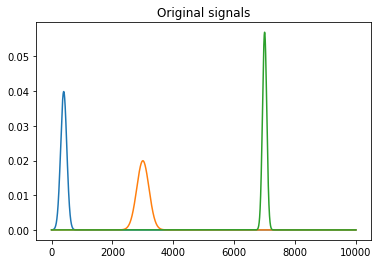

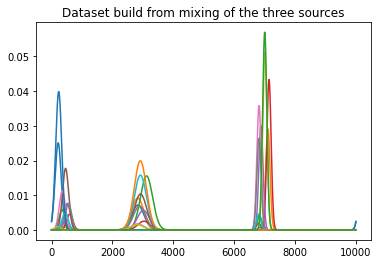

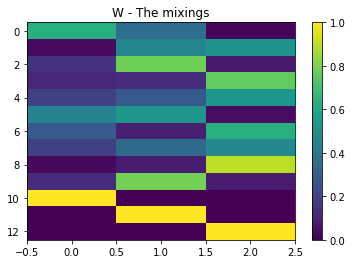

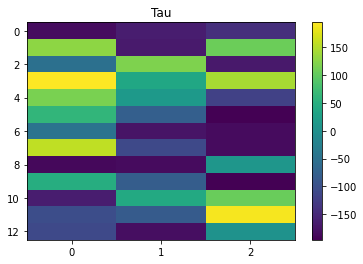

In [2]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 10, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

shift = 200

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return np.real(V)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)
X_clean = shift_dataset(W, H, np.zeros((N, d)))

plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()
plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
plt.title("W - The mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

## Regular NMF

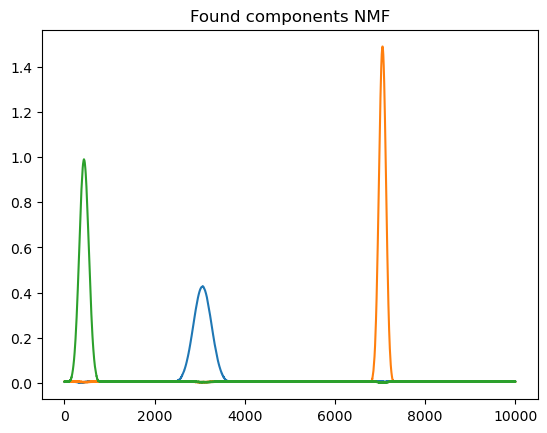

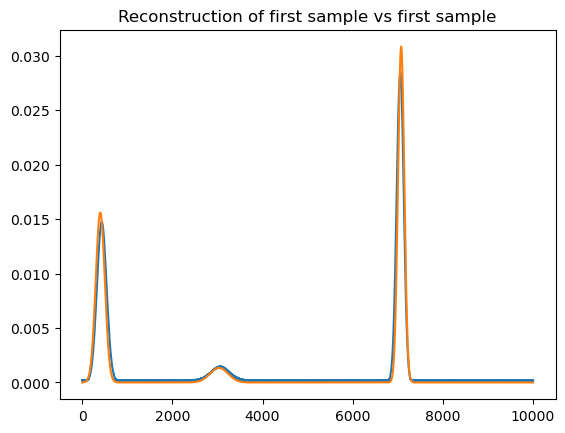

In [7]:

nmf = NMF(X, 3, lr=0.4, factor=0.5)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

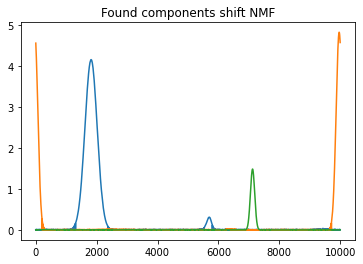

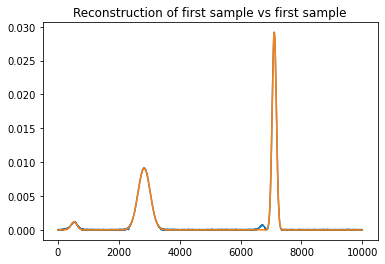

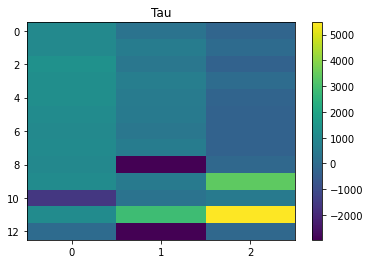

In [8]:

nmf = ShiftNMF(X, 3, lr=0.4, factor=0.9)
W, H, tau = nmf.fit(verbose=True, max_iter=40000)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

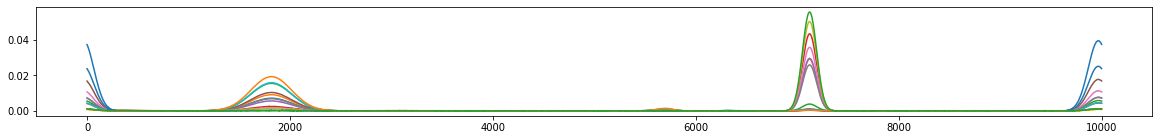

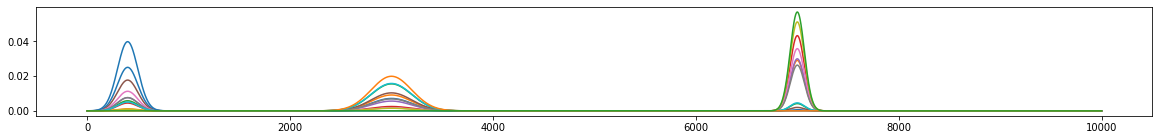

In [12]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(np.matmul(W,H).T)
plt.show()
plt.plot(X_clean.T)
plt.show()

## Regular AA

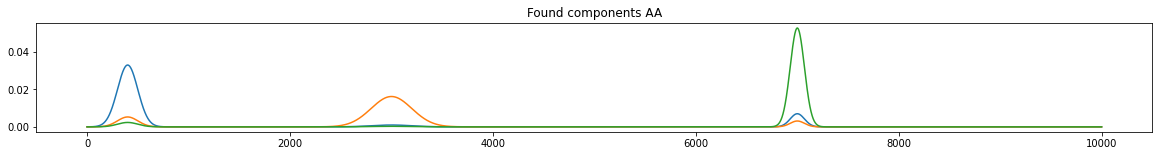

In [17]:
AA = torchAA(X_clean, 3, patience = 10, alpha=1e-5, lr=0.3)
# AA.C = C_init
# AA.S = S_init
C, S = AA.fit(verbose=True)
CX = np.matmul(C, X_clean)
recon_reg = np.matmul(S, CX)

C_init = AA.C
S_init = AA.S


plt.rcParams['figure.figsize'] = [20, 2]
for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()



# plt.plot(recon[1])
# plt.plot(X[1])
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()

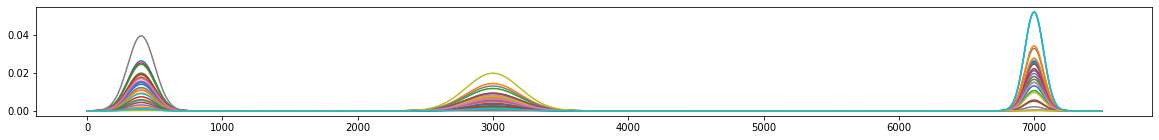

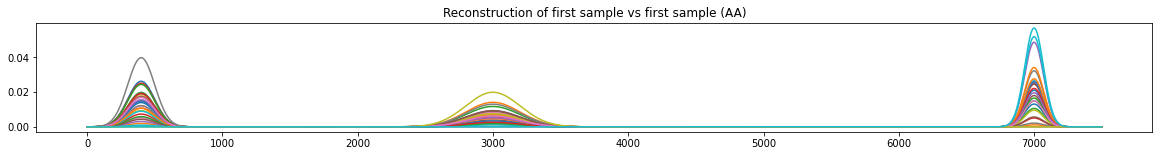

In [198]:
plt.plot(recon_reg.T[:7500])
plt.show()
plt.plot(X_clean.T[:7500])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

In [3]:
# mat = scipy.io.loadmat('helpers/data/NMR_mix_DoE.mat')

# #Get X and Labels. Probably different for the other dataset, but i didn't check :)
# X = mat.get('xData')
# X = X[:10]
AA = torchShiftAA(X_clean, 3, lr=0.3, patience=5, alpha=1e-5, factor=0.9)
# AA.C_tilde = C_init
# AA.C_tilde = torch.nn.Parameter(AA.C_tilde, requires_grad=True)

# AA.S_tilde = S_init
# AA.S_tilde = torch.nn.Parameter(AA.S_tilde, requires_grad=True)

# AA.tau_tilde = torch.nn.Parameter(torch.tensor(tau, dtype=torch.float32), requires_grad=True)

C, S, _ = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

recon_no_shift = np.matmul(S,A)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

# plt.plot(recon.T)
# plt.plot(X.T)
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()



KeyboardInterrupt: 

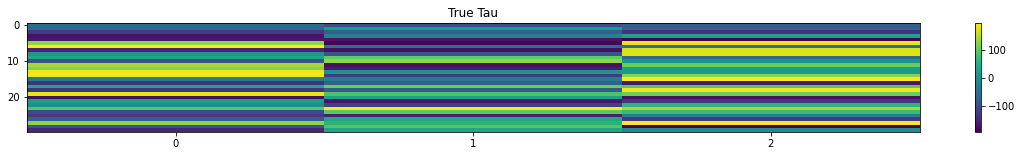

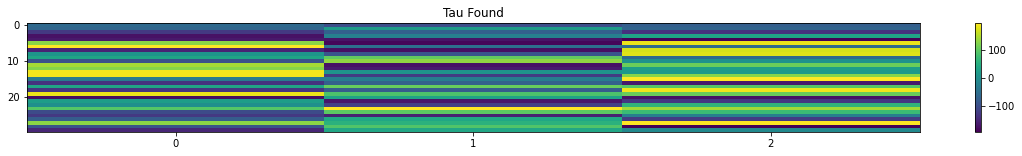

In [ ]:
plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(_, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()

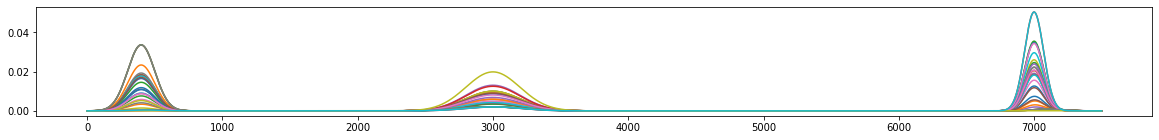

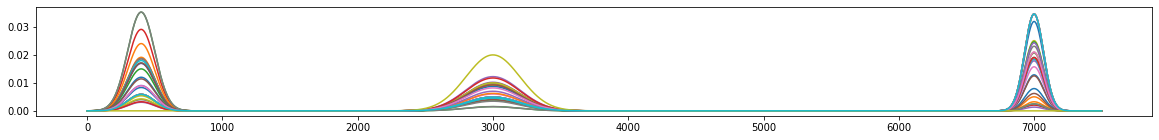

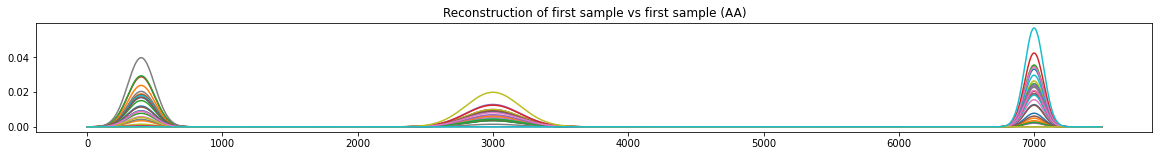

In [221]:
#change figure size
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.show()
plt.plot(recon_reg.T[:lim])
plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

In [ ]:
# tau = AA.fit(verbose=True)

# recon = AA.recon.detach().resolve_conj().numpy()
# A = torch.fft.ifft(AA.A_F).detach().numpy()

# CX = A
# SCX = recon

# for signal in CX:
#     plt.plot(signal)
# plt.title("Found components AA")
# plt.show()

# # plt.plot(recon.T)
# # plt.plot(X.T)
# # plt.title("Reconstruction of first sample vs first sample (AA)")
# # plt.show()



In [ ]:
def expl_var(rec, original):
    return 1-(np.linalg.norm(original - rec, ord="fro")**2 / np.linalg.norm(original - np.mean(original), ord="fro")**2)

In [ ]:
print("Explained variance AA reg: ", expl_var(recon_reg, X_clean))
print("Explained variance AA: ", expl_var(recon, X_clean))

Explained variance AA reg:  1.0
Explained variance AA:  0.721666933107004


In [ ]:
print(explained_variance(recon_reg, X_clean))
print(np.real(explained_variance(recon, X_clean)))

1.0
0.6410087052129281


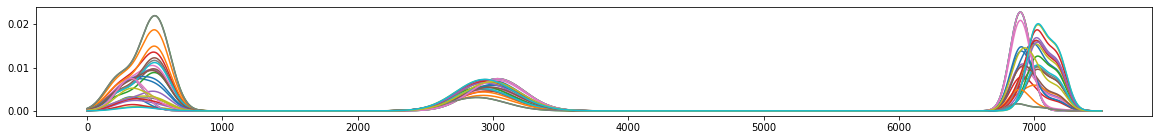

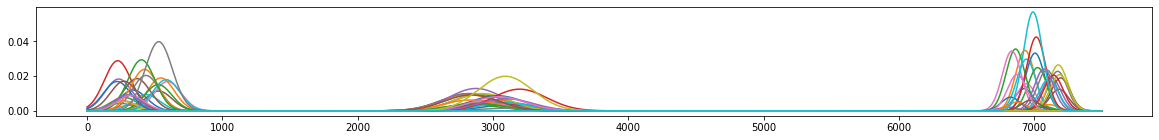

Explained variance AA shift:  0.5898671558274242


In [217]:
recon_shift = AA.recon.detach().numpy()
plt.plot(recon_shift.T[:lim])
plt.show()
plt.plot(X.T[:lim])
plt.show()
print("Explained variance AA shift: ", expl_var(recon_shift, X_clean))

In [9]:
AA = torchShiftAADisc(X, 3, lr=0.3, patience=5, alpha=1e-5, factor=0.999)

C, S, _ = AA.fit(verbose=True, max_iter=1000)

epoch: 1, Loss: 0.18756447268481602
 Tau: 6.244997998398398
epoch: 2, Loss: 0.264434766216153
 Tau: 12.0
epoch: 3, Loss: 0.3242599881369427
 Tau: 17.406895185529212
epoch: 4, Loss: 0.3684301437770735
 Tau: 22.978250586152114
epoch: 5, Loss: 0.40115626698408746
 Tau: 27.982137159266443
epoch: 6, Loss: 0.4324738232713401
 Tau: 31.368774282716245
epoch: 7, Loss: 0.45790777728174603
 Tau: 35.53871128783372
epoch: 8, Loss: 0.47471383471428774
 Tau: 39.191835884530846
epoch: 9, Loss: 0.4947511544148333
 Tau: 42.69660408041839
epoch: 10, Loss: 0.5247206674262748
 Tau: 46.17358552246078
epoch: 11, Loss: 0.5590410957004197
 Tau: 50.18964036531842
epoch: 12, Loss: 0.5898538249731154
 Tau: 54.22176684690383
epoch: 13, Loss: 0.6148228559779618
 Tau: 58.642987645583
epoch: 14, Loss: 0.6362341153913409
 Tau: 62.864934582006846
epoch: 15, Loss: 0.6539816282663289
 Tau: 67.28298447601742
epoch: 16, Loss: 0.668831950757576
 Tau: 71.97221686178632
epoch: 17, Loss: 0.6812754254740081
 Tau: 76.20367445208

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


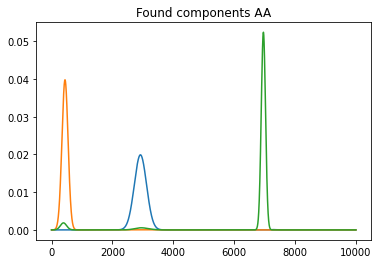

In [10]:

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

recon_no_shift = np.matmul(S,A)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()


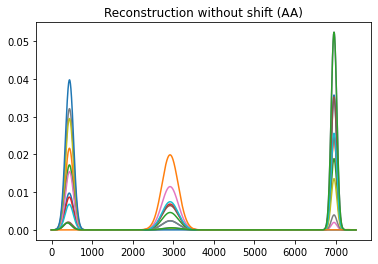

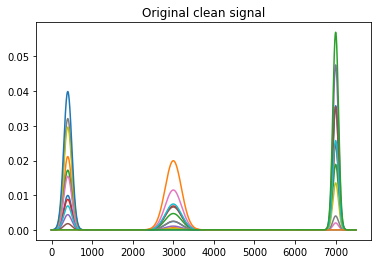

In [11]:
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.title("Reconstruction without shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Original clean signal")
plt.show()

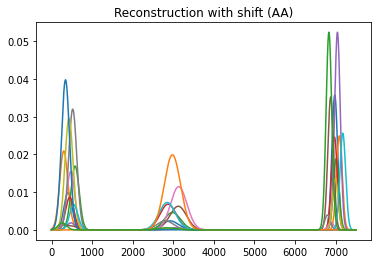

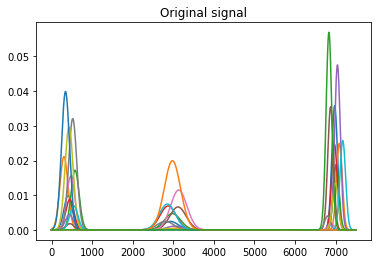

In [12]:
plt.plot(recon.T[:lim])
plt.title("Reconstruction with shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X.T[:lim])
plt.title("Original signal")
plt.show()

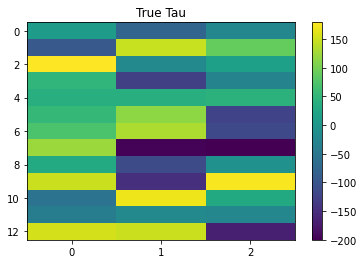

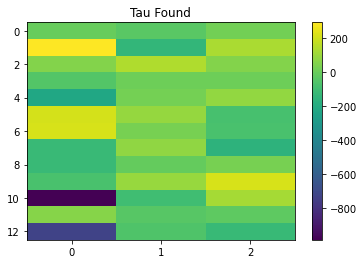

In [13]:
plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(_, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()